## Импортируем необходимые библиотеки

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

## Подготовка данных



In [46]:
# Загрузка данных
images = np.load("/kaggle/input/dl-captcha-new/mds-misis-dl-captchan/images.npy")
labels = np.load("/kaggle/input/dl-captcha-new/mds-misis-dl-captchan/labels.npy")

print(images.shape)
print(labels.shape)

(20000, 48, 48, 3)
(20000,)


In [47]:
print(images[0])
print(labels[0])

[[[144 109 189]
  [153 122 179]
  [169 143 163]
  ...
  [158 130 175]
  [149 117 183]
  [131  91 200]]

 [[128  87 203]
  [138 101 193]
  [160 132 172]
  ...
  [158 129 175]
  [152 121 181]
  [132  93 199]]

 [[127  86 204]
  [135  96 197]
  [145 111 188]
  ...
  [158 129 175]
  [152 121 181]
  [132  93 198]]

 ...

 [[147 115 185]
  [159 131 174]
  [168 142 165]
  ...
  [159 130 174]
  [154 123 179]
  [137 100 194]]

 [[130  90 201]
  [143 108 189]
  [165 138 168]
  ...
  [159 130 175]
  [153 122 180]
  [131  91 200]]

 [[130  90 201]
  [138 102 194]
  [139 102 193]
  ...
  [158 129 175]
  [148 116 184]
  [128  87 203]]]
13


Для подготовки данных проведем нормализацию для массива картинок ([0, 255] → [0, 1]), преобразуем метки в отдельные столбцы и разделим датасет на тренировочный и валидационный.

In [48]:
# Нормализация [0, 255] → [0, 1]
images = images / 255.0

# One-hot кодирование меток (26 классов)
labels = tf.keras.utils.to_categorical(labels, num_classes=26)

# Разделение на train/val (80/20)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

## Создание модели

Набор и последовательность слоев подбирал опытным путем, оценивая метрику accuracy на валидационном датасете.

In [49]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(26, activation='softmax')
])

In [50]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 46, 46, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 44, 44, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 44, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 18, 18, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 5, 5, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,219,674 (4.65 MB)

 Trainable params: 1,218,778 (4.65 MB)

 Non-trainable params: 896 (3.50 KB)

Итак у нашей модели получилось 1,218,778 параметров

## Обучение модели

Проведем бучение модули с 50 эпохами.

In [51]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
)


Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.0526 - loss: 3.4538 - val_accuracy: 0.1133 - val_loss: 2.9882
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2576 - loss: 2.4840 - val_accuracy: 0.5807 - val_loss: 1.3999
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6491 - loss: 1.1157 - val_accuracy: 0.7475 - val_loss: 0.8493
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7812 - loss: 0.7040 - val_accuracy: 0.8015 - val_loss: 0.6144
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8415 - loss: 0.5131 - val_accuracy: 0.8562 - val_loss: 0.4504
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8866 - loss: 0.3682 - val_accuracy: 0.8577 - val_loss: 0.4478
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9156 - loss: 0.2698 - val_accuracy: 0.8735 - val_loss: 0.4133
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9316 - loss: 0.2190 - val_acc

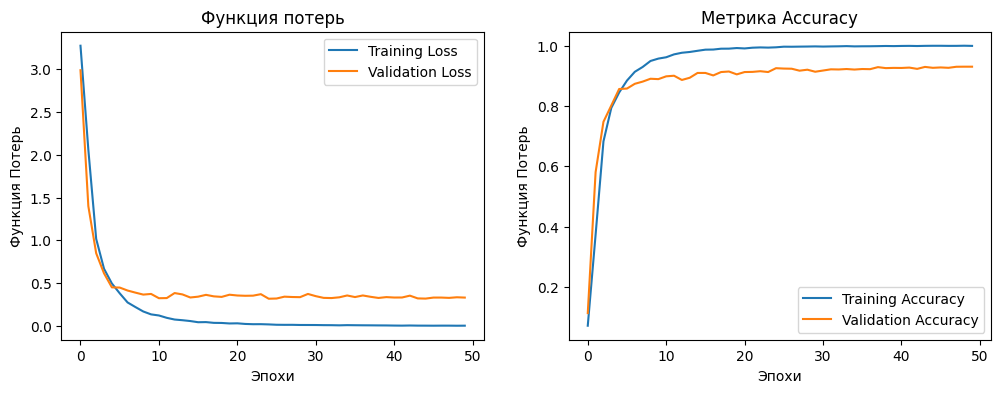

In [52]:
# Визуализация результатов обучения 
plt.figure(figsize=(12, 4))

# Функция потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Функция потерь')
plt.xlabel('Эпохи')
plt.ylabel('Функция Потерь')
plt.legend()

# Метрика Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Метрика Accuracy')
plt.xlabel('Эпохи')
plt.ylabel('Функция Потерь')
plt.legend()

plt.show()

In [53]:
# Предсказание на основе данны из файла images_sub.npy

images_sub = np.load("/kaggle/input/dl-captcha-new/mds-misis-dl-captchan/images_sub.npy")
# Нормализация [0, 255] → [0, 1]
images_sub = images_sub / 255.0
# Предсказания
predictions = model.predict(images_sub)
predicted_classes = predictions.argmax(axis=1)

# Создание файла ответов (submission)
submission = pd.DataFrame({
    'Id': range(len(predicted_classes)),
    'Category': predicted_classes
})
submission.to_csv('/kaggle/working/submission.csv', index=False)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
